# Setup

## Importing modules

In [104]:
import numpy as np
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Loading dataset

In [140]:
dataS = datasets.load_wine()
# dataS = datasets.load_breast_cancer()
# dataS = datasets.load_iris()

X, y = dataS.data, dataS.target

print(f'Number of input features (d): {X.shape[1]}')
print(f'Unique target classes: {np.unique(y)}')


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,
    stratify=y, random_state=0)

Number of input features (d): 4
Unique target classes: [0 1 2]


In [142]:
# Print the different input features
print(dataS.feature_names)
# Print the different target names
print(dataS.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


# LDA

## Step 1: Standardize the dataset

In [126]:
sc = StandardScaler()
sc.fit(X_train)

# Transform (standardise) both X_train and X_test with mean and standard deviation from training data
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

## Step 2: For each class, compute the $d$-dimensional mean vector

Each mean vector, $\textbf{m}_i$, stores the mean feature value, $\mu_m$, with respect to the examples of class i:

\begin{equation*}
    \mathbf{m}_i = \frac{1}{n_i} \sum_{\mathbf{x} \in D_i} \mathbf{x}
\end{equation*}

This results in three mean vectors:

\begin{equation*}
    \mathbf{m}_i = \begin{bmatrix}
    \mu_{i,alcohol} \\
    \mu_{i,malic\;acid} \\
    \vdots  \\
    \mu_{i,proline}
    \end{bmatrix}, \; i \in \{1, 2, 3\}
\end{equation*}

In [127]:
classes = np.unique(y)
mean_vectors = [np.mean(X_train_std[y_train == i], axis=0) for i in classes]
# print(mean_vectors)

## Step 3: Construct the between-class scatter matrix, $\mathbf{S}_B$, and the within-class scatter matrix, $\mathbf{S}_W$

For this dataset let $c$ be the number of classes in the wine dataset ($c = 3$), and $D_i$ be the samples/individual data points that correspond to class $i$. Using the mean vectors, we can now compute the within-class scatter matrix, $\mathbf{S}_W$:

\begin{equation*}
    \mathbf{S}_W = \sum_{i = 1}^{c} \mathbf{S}_{Wi}
\end{equation*}

This is calculated by summing up the individual scatter matrices, $\mathbf{S}_{Wi}$, of each individual class $i$:

\begin{equation*}
    \mathbf{S}_{Wi} = \sum_{\mathbf{x} \in D_i} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T
\end{equation*}

In [128]:
d = X_train_std.shape[1] # number of input features
S_W = np.zeros((d, d))
for i, m_i in zip(classes, mean_vectors):
    class_scatter = np.zeros((d, d))
    for x in X_train_std[y_train == i]:
        x, m_i = x.reshape(d, 1), m_i.reshape(d, 1)
        class_scatter += (x - m_i).dot((x - m_i).T)
    S_W += class_scatter
# print(S_W)

The problem with this approach is that when we compute the within class scatter matrices we also assume that the class labels are uniformly distributed. This is not the case for the wine dataset as you can see below: 

In [129]:
print(f'Class label distribution: {np.bincount(y_train)}')

Class label distribution: [35 35 35]


To account for this we divide the individual class scatter matrices by the number of samples in each class before summing the together to the within class scatter matrix. This is equivilant to computing the covariance matrices of the input matrix for each class.

\begin{align*}
    \mathbf{S}_W &= \sum_{i = 1}^{c} \frac{1}{n_i} \mathbf{S}_{Wi} \\
                 &= \sum_{i = 1}^{c} \frac{1}{n_i} \left(\sum_{\mathbf{x} \in D_i} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T \right) \\
                 &= \sum_{i = 1}^{c} \frac{1}{n_i} \sum_{\mathbf{x} \in D_i} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T \\
                 &= \sum_{i = 1}^{c} \mathrm{Cov}(\mathbf{X}_i) \\
\end{align*}

In the book they use the notation $\Sigma_i$ to refer to the individual class covariance matrices. 

In [130]:
S_W = np.zeros((d, d))
for i in classes:
    class_scatter = np.cov(X_train_std[y_train == i].T)
    S_W += class_scatter
# print(S_W)

The between-class scatter matrix, $\mathbf{S}_B$, is given by the equation below. 

\begin{align*}
    \mathbf{S}_B = \frac{1}{n_i}\sum_{i = 1}^{c} n_i (\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T
\end{align*}

Where $\mathbf{m}$ is the overall mean of the entire dataset, with all classes included. 

In [131]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1) # Make column vector
S_B = np.zeros((d, d))
for i, m_i in enumerate(mean_vectors):
    n = X_train_std[y_train == i + 1, :].shape[0]
    m_i = m_i.reshape(d, 1) # make column vector
    S_B += n * (m_i - mean_overall).dot((m_i - mean_overall).T)
# print(S_B)

## Step 4: Compute the eigenvectors and corresponding eigenvalues of the matrix, $\mathbf{S}_{W}^{-1} \mathbf{S}_B$

In [132]:
matrix_product = np.linalg.inv(S_W).dot(S_B)
eigen_values, eigen_vectors = np.linalg.eig(matrix_product)

## Step 5: Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors

In [133]:
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_vectors))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [134]:
for pair in eigen_pairs:
    print(pair[0])

632.3110915210256
5.954462196661441
1.1038667034769523e-13
7.202258548320394e-14


## Step 6: Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d \times k$-dimensional transformation matrix, $\mathbf{W}$; the eigenvectors are the columns of this matrix.

We choose the two most discriminating linear discriminants to create the transformation matrix $\mathbf{W}$.

In [135]:
# W = np.hstack([eigen_pairs[i][1][:, np.newaxis].real for i in range(2)])
W = np.hstack((eigen_pairs[0][1].reshape(X_train_std.shape[1], 1), 
               eigen_pairs[1][1].reshape(X_train_std.shape[1], 1)))
# print(W)

## Step 7: Project the samples of $\mathbf{X}$ onto the new feature subspace using the transformation matrix, $\mathbf{W}$

In [136]:
X_train_lda = X_train_std.dot(W)
X_test_lda  = X_test_std.dot(W)

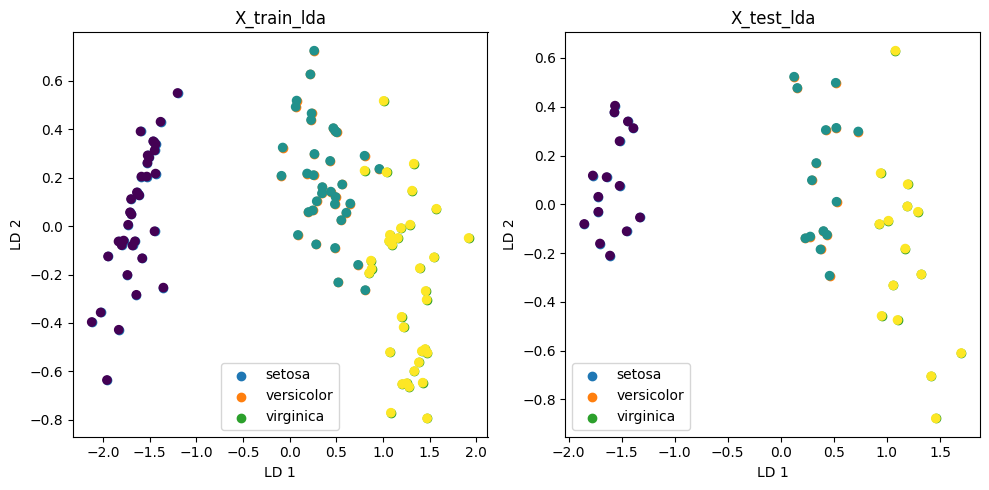

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for X_train_lda and X_test_lda
for class_idx in classes:
    axs[0].scatter(X_train_lda[y_train == class_idx, 0], X_train_lda[y_train == class_idx, 1], label=dataS.target_names[class_idx])
    axs[1].scatter(X_test_lda[y_test == class_idx, 0],   X_test_lda[y_test == class_idx, 1],   label=dataS.target_names[class_idx])

axs[0].set_xlabel('LD 1')
axs[0].set_ylabel('LD 2')
axs[0].set_title('X_train_lda')
axs[0].legend()

axs[1].set_xlabel('LD 1')
axs[1].set_ylabel('LD 2')
axs[1].set_title('X_test_lda')
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot of "cumulative discriminability"

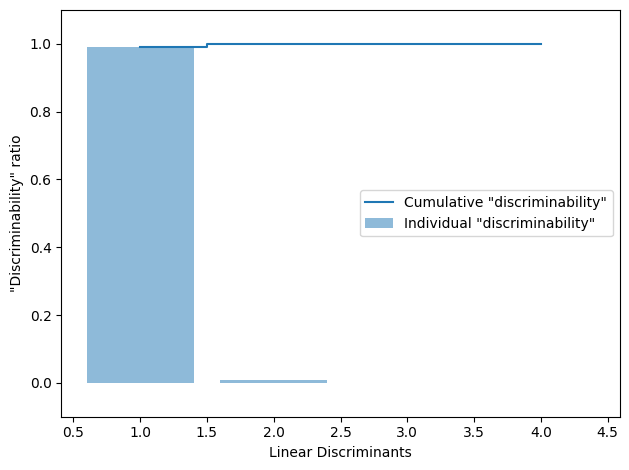

In [138]:
tot = sum(eigen_values.real)
discr = [(eigen_pair[0] / tot) for eigen_pair in eigen_pairs]
cum_discr = np.cumsum(discr)
plt.bar(range(1, len(eigen_pairs) + 1), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, len(eigen_pairs)+ 1), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()